Import libraries and clean data

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd


Load in Train 

In [36]:
data_read = pd.read_csv('All Trading Simulation Output.csv')
data_read = data_read.drop(columns=['Unnamed: 0'])
data_read['DateTime_Minute'] = pd.to_datetime(data_read['DateTime_Minute'], format='%Y-%m-%d %H:%M:%S')

C:\Users\Tim\AppData\Local\Temp\ipykernel_13460\3339195831.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data_read = pd.read_csv('All Trading Simulation Output.csv')


Get extra features 

In [41]:
data_read['Hour'] = data_read['DateTime_Minute'].dt.hour
data_read['Minute'] = data_read['DateTime_Minute'].dt.minute
data_read['Second'] = data_read['DateTime_Minute'].dt.second
# data_read['Hour'] = data_read['Hour'].fillna(-1).astype(int)
# data_read['Minute'] = data_read['Minute'].fillna(-1).astype(int)
# data_read['Second'] = data_read['Second'].fillna(-1).astype(int)

# Calculate moving averages for bid and ask prices
data_read['MA5_Bid'] = data_read['Bid1_Price'].rolling(window=5).mean()
data_read['MA10_Bid'] = data_read['Bid1_Price'].rolling(window=10).mean()
data_read['MA5_Ask'] = data_read['Ask1_Price'].rolling(window=5).mean()
data_read['MA10_Ask'] = data_read['Ask1_Price'].rolling(window=10).mean()

# Create lagged features
data_read['Weighted_Avg_Bid_Price_Lag1'] = data_read['Bid1_Price'].shift(1)
data_read['Weighted_Avg_Ask_Price_Lag1'] = data_read['Ask1_Price'].shift(1)

In [42]:
# Train: Jan - April
train_data = data_read[data_read['DateTime_Minute'] <= '2025-04-30'].copy()
# Val: May
validation_data = data_read[(data_read['DateTime_Minute'] >= '2025-05-01') & (data_read['DateTime_Minute'] < '2025-06-01')].copy()
# Test: June
test_data = data_read[(data_read['DateTime_Minute'] >= '2025-06-01') & (data_read['DateTime_Minute'] < '2025-07-01')].copy()

In [45]:
# define the target
target = 'Signal'

# Select features
features = ['Bid1_Price', 'Ask1_Price', 'Bid1_Volume', 'Ask1_Volume', 
            'Bid_Ask_Spread', 'Market_Depth_Bid', 'Market_Depth_Ask', 
            'Historical_Volatility', 'Cumulative_Volume_Difference', 'Order_imbalance', 
            'MA5_Bid', 'MA10_Bid', 'MA5_Ask', 'MA10_Ask', 'RSI', 'MACD', 
            'Weighted_Avg_Bid_Price_Lag1', 'Weighted_Avg_Ask_Price_Lag1']


X_train = train_data[features]
y_train = train_data[target]

X_val = validation_data[features]
y_val = validation_data[target]

X_test = test_data[features]
y_test = test_data[target]

In [54]:
unique_test_labels = np.unique(y_test)
unique_pred_labels = np.unique(y_test_pred)
print("Unique test labels:", unique_test_labels)
print("Unique predicted labels:", unique_pred_labels)

Unique test labels: ['Hold']
Unique predicted labels: ['Buy' 'Hold']


Scale Model(not neccesarily needed)

In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Do Gridsearch to get best params

In [48]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 400],  # no.of trees
    'max_depth': [None, 10, 20, 30],  # max depth of the tree
    'min_samples_split': [2, 5, 10],  # min no. samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # min no. of samples required at a leaf node
}

# RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=2, scoring='accuracy', n_jobs=-1)

Print Best Params

In [49]:
# Fit grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score from the grid search
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.53


Get validation accuracy using grid search parameters

In [50]:
# Prediction and evaluation using scaled validation data
y_val_pred = grid_search.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.41833333333333333


C:\Users\Tim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Do on Test Data

In [51]:
# Prediction and evaluation using scaled test data
y_test_pred = grid_search.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.3326797385620915


C:\Users\Tim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Plot Result

C:\Users\Tim\AppData\Local\Temp\ipykernel_13460\457669220.py:7: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (3).

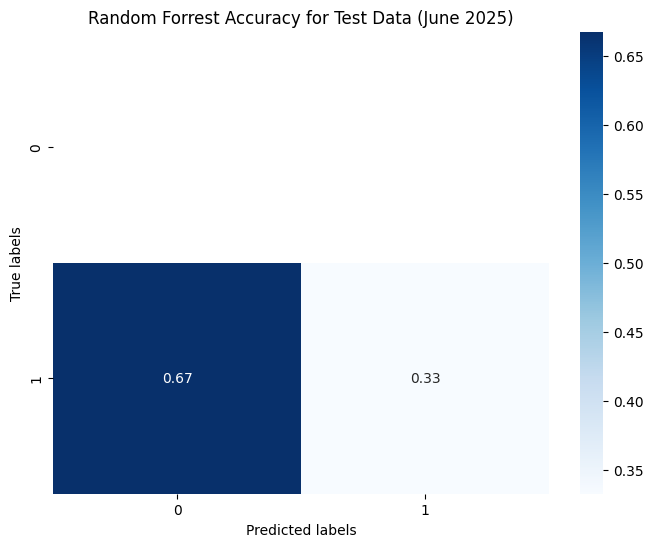

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap="Blues", fmt=".2f")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Random Forrest Accuracy for Test Data (June 2025)')
ax.xaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])
ax.yaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])

plt.show()

Plot the tree

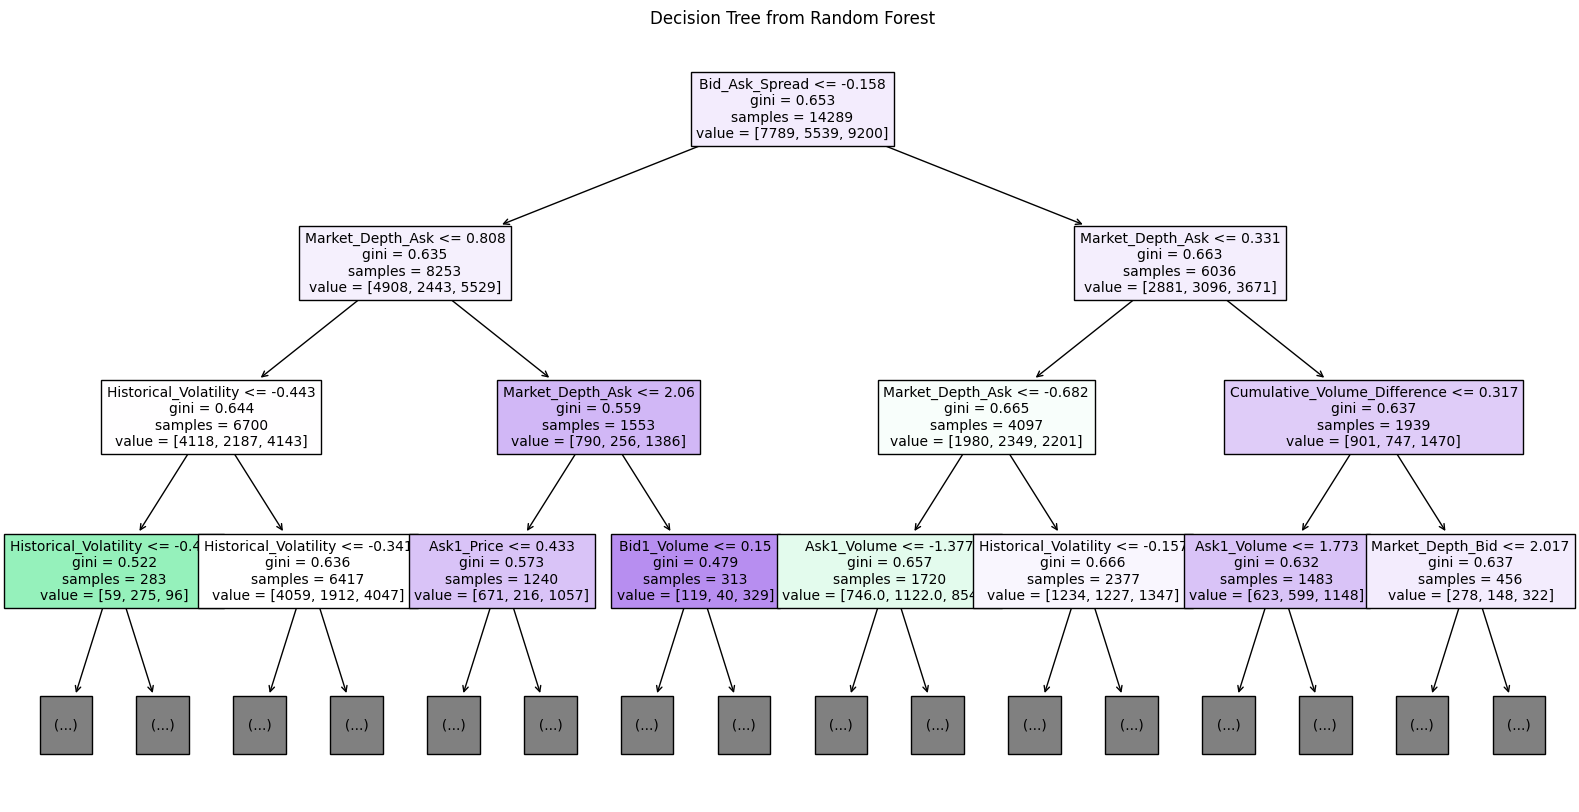

In [9]:
from sklearn.tree import plot_tree

# Select the first tree
first_tree = rf_model.estimators_[0]

# Plot the tree
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(first_tree, filled=True, feature_names=features.columns, max_depth=3, fontsize=10, ax=ax)
plt.title("Decision Tree from Random Forest")
plt.show()